# Predicting Houseplant Watering
## Using Machine Learning

**Final Report**

University of London

BSc Computer Science (Machine Learning and Artificial Intelligence)

Author: Simeon Totev

## Read data from CSV

First, we prepare some common variables for reading from the CSV file.

In [2]:
# csv reading vals
dataFile = "./data-2024-02-10.csv"

# columns
colTimestamp = "timestamp"
colSoilMoisture = "soil_moisture"
colAirHumidity = "air_humidity"
colAirTemperature = "air_temperature"
colMinutesLeft = "minutes_left"
colUrgency = "urgency"

### Data sanitisation

The input data has some gaps due to malfunctions with the soil moisture sensor. The gaps will be filled in using linear interpolation with `df.interpolate`. We create a helper function `addMissingRows` which creates the missing gaps of the measurements in intervals of 10 minutes and 10 seconds (to be similar to the actual measurements which came in at the same interval).

Lastly, we shall plot the different columns to see how they look visually.

Initial dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        5171 non-null   datetime64[ns]
 1   air_humidity     5171 non-null   float64       
 2   air_temperature  5171 non-null   float64       
 3   soil_moisture    5171 non-null   float64       
 4   minutes_left     5171 non-null   int64         
 5   urgency          5171 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 242.5+ KB
None
After adding new rows:
<class 'pandas.core.frame.DataFrame'>
Index: 8208 entries, 0 to 5170
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        8208 non-null   datetime64[ns]
 1   air_humidity     5171 non-null   float64       
 2   air_temperature  5171 

<Axes: xlabel='timestamp'>

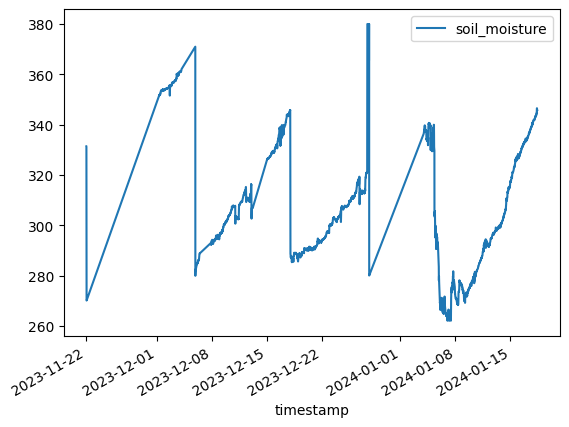

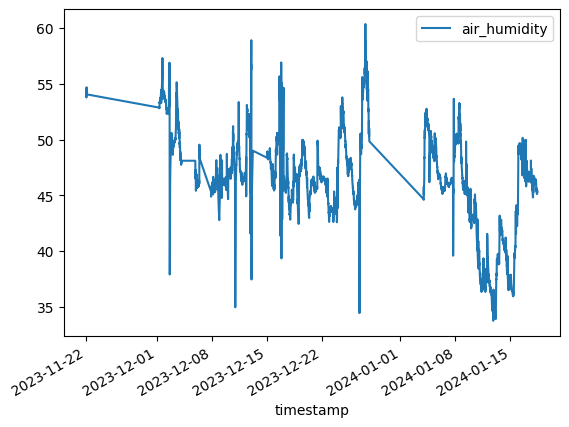

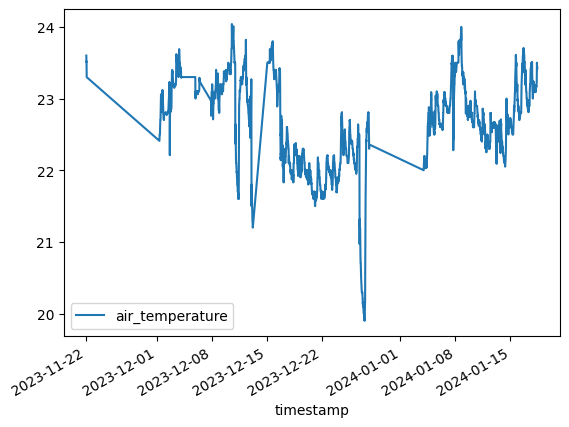

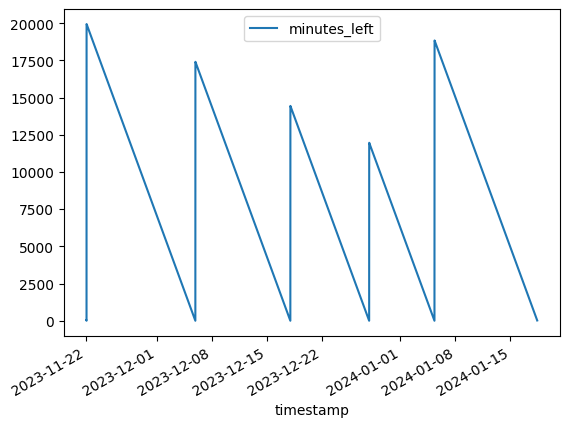

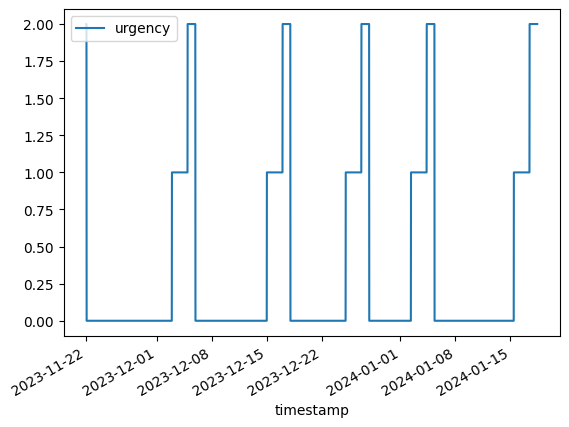

In [4]:
from datetime import timedelta
import pandas as pd

# introduce missing rows
def addMissingRows(dfIn, deltaMinutes = 10, deltaSeconds = 10):
    # ensure values are sorted by timestamp
    dfIn.sort_values(by=colTimestamp, inplace=True)
    delta = timedelta(minutes=deltaMinutes, seconds=deltaSeconds)

    # initialize new rows
    newData = [];

    for index, row in dfIn.iterrows():
        # get the current timestamp
        currentTimestamp = dfIn.iloc[index][colTimestamp]

        # get the next timestamp
        try:
            nextTimestamp = dfIn.iloc[index+1][colTimestamp]
        except:
            # if it does not exist, exit from the for loop
            break;

        # keep creating new rows with a delta
        # until it is about to overlap with nextTimestamp
        newRowTimestamp = currentTimestamp
        while newRowTimestamp + delta < nextTimestamp:
            newRowTimestamp += delta

            newData.append({
                colTimestamp: newRowTimestamp
            })

    # create a new dataframe with the new rows
    dfNew = pd.DataFrame(newData, columns = dfIn.columns)

    # combine both dataframes
    dfResult = pd.concat([dfIn, dfNew])
    dfResult.sort_values(by=colTimestamp, inplace=True)

    return dfResult

def calcUrgency(x):
    if x[colMinutesLeft] == 0 or x[colMinutesLeft] >= 24 * 3 * 60:
        # NOT_NEEDED
        return 0

    if x[colMinutesLeft] >= 24 * 60:
        # SOON
        return 1

    # URGENT
    return 2

# read dataframe from csv
df = pd.read_csv(dataFile, parse_dates=[colTimestamp])

print("Initial dataframe:")
print(df.info())

deltaMinutes = 10
deltaSeconds = 10
df = addMissingRows(df, deltaMinutes, deltaSeconds)

print("After adding new rows:")
print(df.info())

# create new dataframe with the needed columns
df = pd.DataFrame(df[[colTimestamp, colSoilMoisture, colAirHumidity, colAirTemperature, colMinutesLeft]])

# index by timestamp
df = df.set_index(colTimestamp)

# interpolate missing data
df.interpolate(method="time", inplace=True)

# calculate the urgency again
df[colUrgency] = df.apply(calcUrgency, axis=1)

# clip values of soil moisture
soilMoistureUpper = 380
soilMoistureLower = 220
df[colSoilMoisture] = df[colSoilMoisture].clip(lower=soilMoistureLower, upper=soilMoistureUpper)

# print the result
print(df.info())

print(df.describe())

# plot the dataframe
df.plot(y=colSoilMoisture)
df.plot(y=colAirHumidity)
df.plot(y=colAirTemperature)
df.plot(y=colMinutesLeft)
df.plot(y=colUrgency)

## Prepare data for ML

Our data has to be transformed into features `X` and labels `y`.

For `X`, we shall select the columns for soil moisture, air humidity, and air temperature. We apply the `StandardScaler` by Scikit Learn to scale the data into values suitable for ML.

The labels `y` are transformed into a categorical vector of size 3 where each bit indicates whether the urgency is `NOT_NEEDED`, `SOON` or `URGENT`. For example, `(0, 0, 1)` indicates `URGENT`. The conversion is adapted from Brownlee's tutorial [1].

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import keras.utils as np_utils

# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
def getCategoricalY(df):
    encoder = LabelEncoder()
    encoder.fit(df[colUrgency])
    encodedY = encoder.transform(df[colUrgency])
    return np_utils.to_categorical(encodedY)

# scales the features using the sklearn StandardScaler [7]
def scaleFeatures(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

xRaw = df[[colSoilMoisture, colAirHumidity, colAirTemperature]].to_numpy()

X = scaleFeatures(xRaw)
y = getCategoricalY(df)

print("X:", X)
print("X.shape:", X.shape)
print("y:", y)
print("y.shape:", y.shape)

X: [[ 0.83950828  1.43064764  1.61655899]
 [ 0.83393187  1.38964818  1.58263491]
 [ 0.83273692  1.38053718  1.46390061]
 ...
 [ 1.41626828 -0.50543825  1.2942802 ]
 [ 1.41507334 -0.5737707   1.2942802 ]
 [ 1.41348008 -0.53960448  1.32820428]]
X.shape: (8208, 3)
y: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
y.shape: (8208, 3)


## Preparation for LSTM and GRU

To train the RNNs, we want to be able to reshape our training set, such that an array of shape `(X, Y)` transforms into `(X, T, Y)` where `T` corresponds to the timesteps for the recurrent neural networks. This is how we feed historical data into the neural network. The reshaping function `reshapeSet` is adapted from Yadav's blogpost [2].

We also apply TimeSeriesSplit as a variant of cross-validation. However, we cannot use K-fold cross-validation as the data must remain sequential, and not get shuffled. In the TimeSeriesSplit, we get N number of splits that look as follows:

1. `TSSS`
2. `TTSS`
3. `TTTS`

Where `T` denotes data for training and `S` denotes data for validation.

The function `summariseReports` helps us by giving an overview of the average performance across all the cross-validation steps.

In [9]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# reshape data from (X, Y) to (X, T, Y)
def reshapeSet(rows, steps):
    newRows = []
    
    for i in range(steps, rows.shape[0] + 1):
        newRows.append( rows[ i-steps:i, ] )

    return np.array(newRows)

# get timeseries reshaped data
def timeSeriesReshapedData(X, y, nSplits, steps):
    # split the time series data
    tscv = TimeSeriesSplit(n_splits=nSplits)

    results = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # reshape the data to fit the RNN model
        X_train_reshaped = reshapeSet(X_train, steps)
        X_test_reshaped = reshapeSet(X_test, steps)
        y_train_reshaped = y_train[ steps-1:y_train.shape[0], ]
        y_test_reshaped = y_test[ steps-1:y_train.shape[0], ]
        
        results.append((X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped))
    
    return results

def plotTrainHistory(history, epochs):
    train_loss = history.history["loss"]
    train_val_loss = history.history["val_loss"]
    x = range(1, epochs + 1)
    
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(4, 2))
    plt.plot(x, train_loss, blue_dots, label = 'Training loss')
    plt.plot(x, train_val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

def valuesAvgStd(values):
    avg = np.round(np.average(values), 3)
    std = np.round(np.std(values), 3)

    return str(avg) + " ± " + str(std)

def summariseReports(reports):
    # accuracy
    lines = []

    lines.append([
        "accuracy",
        "NOT_NEEDED/precision",
        "NOT_NEEDED/recall",
        "SOON/precision",
        "SOON/recall",
        "URGENT/precision",
        "URGENT/recall"
    ])
    
    lines.append([
        valuesAvgStd([ r["accuracy"] for r in reports ]),
        valuesAvgStd([ val["precision"] for val in [ r["0"] for r in reports ] ]),
        valuesAvgStd([ val["recall"] for val in [ r["0"] for r in reports ] ]),
        valuesAvgStd([ val["precision"] for val in [ r["1"] for r in reports ] ]),
        valuesAvgStd([ val["recall"] for val in [ r["1"] for r in reports ] ]),
        valuesAvgStd([ val["precision"] for val in [ r["2"] for r in reports ] ]),
        valuesAvgStd([ val["recall"] for val in [ r["2"] for r in reports ] ])
    ])

    for line in lines:
        print(",".join(line))

# Adapt the neural network models to not be trained on a GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Training LSTM

We create an LSTM model with the following layers:

1. LSTM layer
2. Dropout layer to ensure that training balances across multiple nodes. This is suggested in Yadav's tutorial [2].
3. Dense layer to apply the `softmax` activation and produce a 3-value vector for the neural network's output.

We extract the hyperparameters for the number of time series splits, the number of training epochs, time steps and training batch size.

Finally, we visualise the training of each epoch and produce a final average result for all training splits.

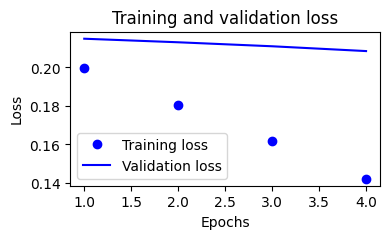

50/50 [==============================] - 0s 2ms/step


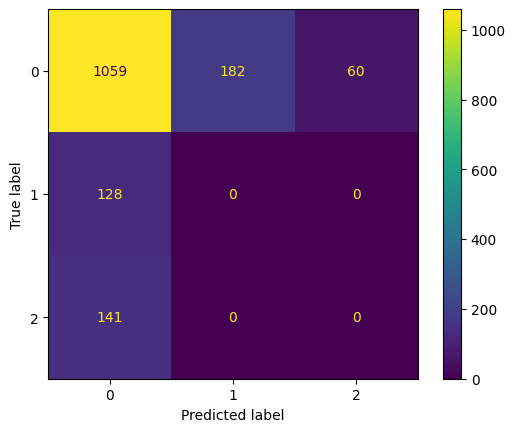

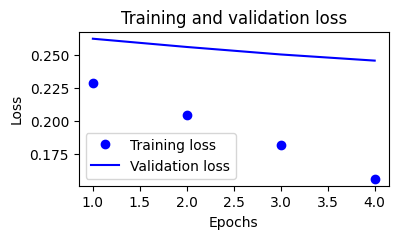

50/50 [==============================] - 0s 2ms/step


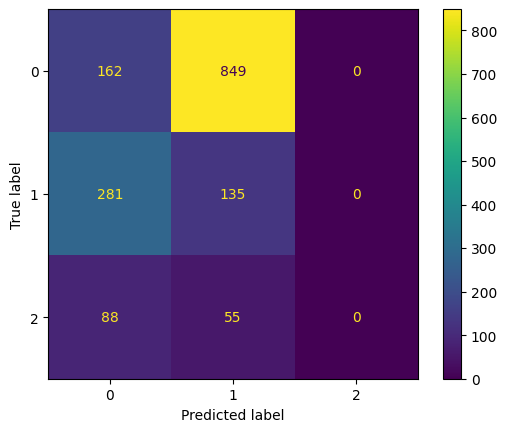

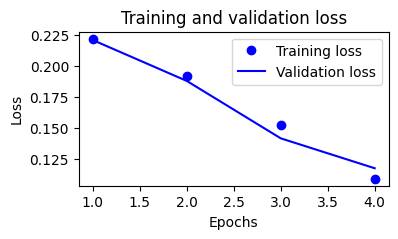

50/50 [==============================] - 0s 2ms/step


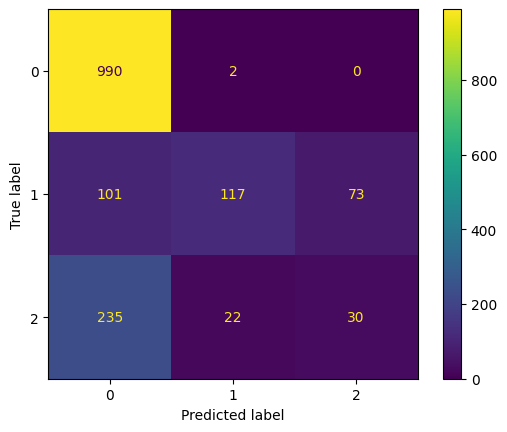

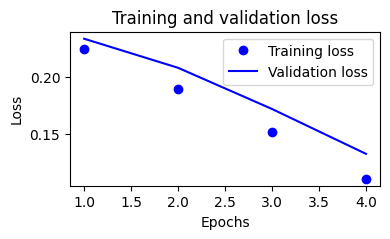

50/50 [==============================] - 0s 2ms/step


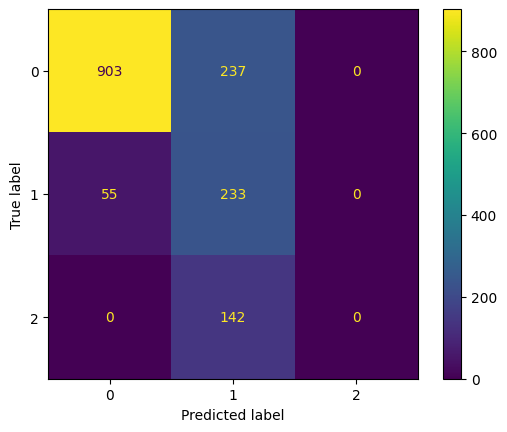

accuracy,NOT_NEEDED/precision,NOT_NEEDED/recall,SOON/precision,SOON/recall,URGENT/precision,URGENT/recall
0.578 ± 0.225,0.698 ± 0.238,0.691 ± 0.317,0.335 ± 0.317,0.384 ± 0.288,nan ± nan,0.026 ± 0.045


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def getModelLSTM(inputShape, outputSize):
    # build the model
    model = Sequential()
    
    model.add(LSTM(units=10, input_shape=inputShape))
    model.add(Dropout(0.2))
    model.add(Dense(units=outputSize, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=["accuracy"])

    return model

def trainLSTM(modelEpochs, batchSize, nSplits, timeSteps):
    # init reports
    reports = []
    
    for X_train_reshaped, y_train, X_test_reshaped, y_test in timeSeriesReshapedData(X, y, nSplits, timeSteps):
        inputShape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
        outputSize = y_train.shape[1]
        
        model = getModelLSTM(inputShape, outputSize)
    
        # train the model
        trainHistory = model.fit(
            X_train_reshaped,
            y_train,
            verbose=0,
            epochs=modelEpochs,
            batch_size=batchSize,
            validation_data=(X_test_reshaped, y_test)
        )
    
        plotTrainHistory(trainHistory, modelEpochs)

        # make prediction
        y_pred = model.predict(X_test_reshaped)
        y_pred_bool = np.argmax(y_pred, axis=1)
        y_test_bool = np.argmax(y_test, axis=1)

        cr = classification_report(y_test_bool, y_pred_bool, zero_division=np.nan, output_dict=True)
        reports.append(cr)

        cm = confusion_matrix(y_test_bool, y_pred_bool)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()

    return reports

# LSTM hyperparameters
nSplits = 4
modelEpochs = 4
timeSteps = 72
batchSize = 256

reports = trainLSTM(modelEpochs, batchSize, nSplits, timeSteps)
summariseReports(reports)

## Training GRU

Very similar to the LSTM, the GRU is composed of 3 layers.

1. GRU layer
2. Dropout layer
3. Dense layer with the `softmax` activation

Again, we separate out hyperparameters for number of time series splits, epochs, time steps, and batch size.

Finally, we train the network and produce visualisations and averages of all time series splits.

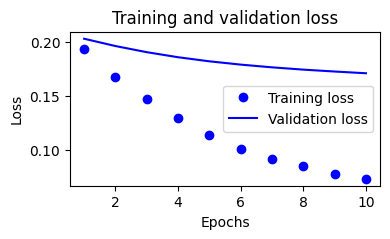

52/52 [==============================] - 0s 673us/step


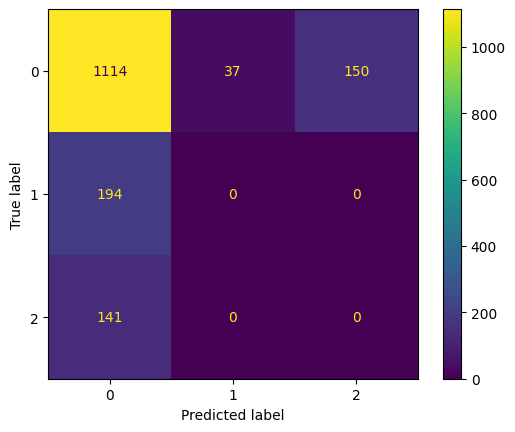

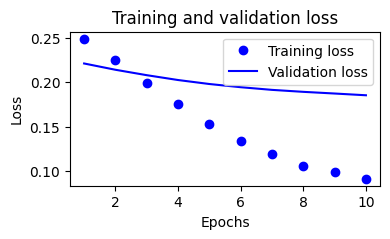

52/52 [==============================] - 0s 676us/step


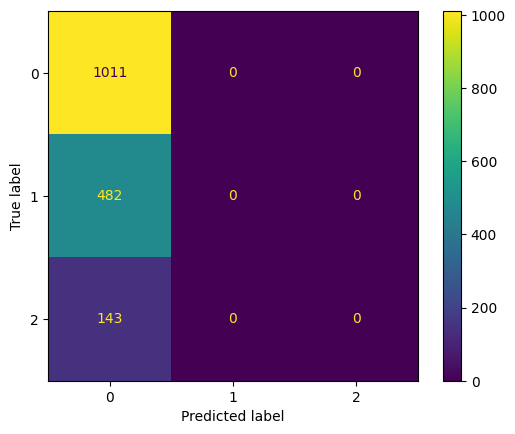

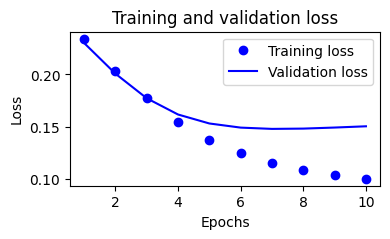

52/52 [==============================] - 0s 670us/step


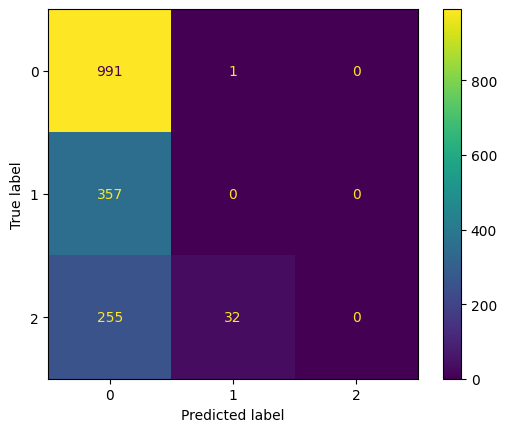

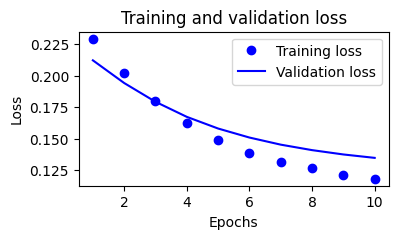

52/52 [==============================] - 0s 702us/step


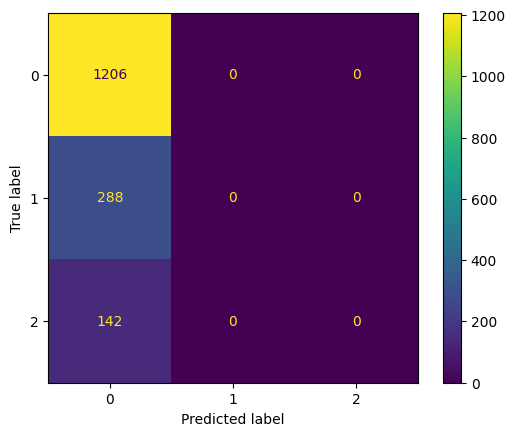

accuracy,NOT_NEEDED/precision,NOT_NEEDED/recall,SOON/precision,SOON/recall,URGENT/precision,URGENT/recall
0.66 ± 0.053,0.686 ± 0.068,0.964 ± 0.062,nan ± nan,0.0 ± 0.0,nan ± nan,0.0 ± 0.0


In [12]:
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import SGD

def getModelGRU(inputShape, outputSize):
    # build the model
    model = Sequential()
    model.add(GRU(units=10, input_shape=inputShape))
    model.add(Dropout(0.2))
    model.add(Dense(units=outputSize, activation='softmax'))

    model.compile(
        optimizer=SGD(),
        loss='mean_squared_error',
        metrics=["accuracy"]
    )
    
    return model

def trainGRU(modelEpochs, batchSize, nSplits, timeSteps):
    # init reports
    reports = []
    
    for X_train_reshaped, y_train, X_test_reshaped, y_test in timeSeriesReshapedData(X, y, nSplits, timeSteps):
        inputShape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
        outputSize = y_train.shape[1]

        model = getModelGRU(inputShape, outputSize)

        trainHistory = model.fit(
            X_train_reshaped,
            y_train,
            verbose=0,
            epochs=modelEpochs,
            batch_size=batchSize,
            validation_data=(X_test_reshaped, y_test)
        )

        plotTrainHistory(trainHistory, modelEpochs)

        # make prediction
        y_pred = model.predict(X_test_reshaped)
        y_pred_bool = np.argmax(y_pred, axis=1)
        y_test_bool = np.argmax(y_test, axis=1)

        cr = classification_report(y_test_bool, y_pred_bool, zero_division=np.nan, output_dict=True)
        reports.append(cr)

        cm = confusion_matrix(y_test_bool, y_pred_bool)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()

    return reports

nSplits = 4
modelEpochs = 10
timeSteps = 6
batchSize = 64

reports = trainGRU(modelEpochs, batchSize, nSplits, timeSteps)
summariseReports(reports)

## Training Random Forest

We shall use the `RandomForestClassifier` as provided by Scikit Learn, and train it on a K-fold cross-validation split of our data.

We apply hyperparameters for the number of splits, the number of forest estimators, and a random state number.

Finally, we visualise the confusion matrices and a classification report.

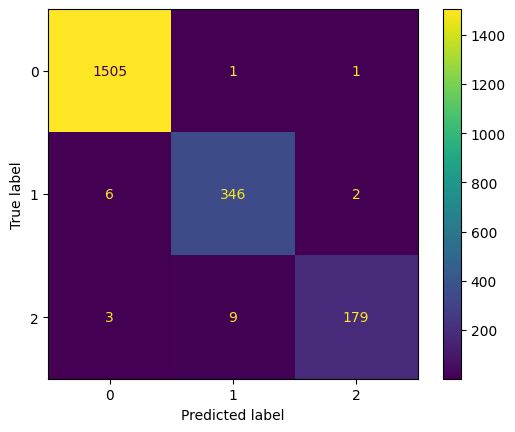

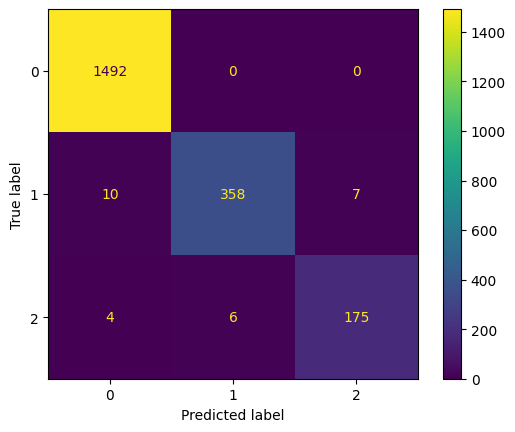

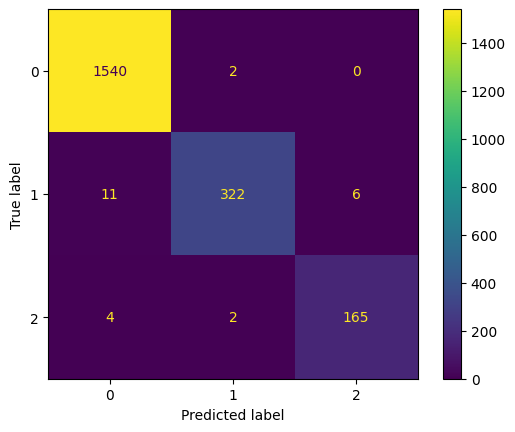

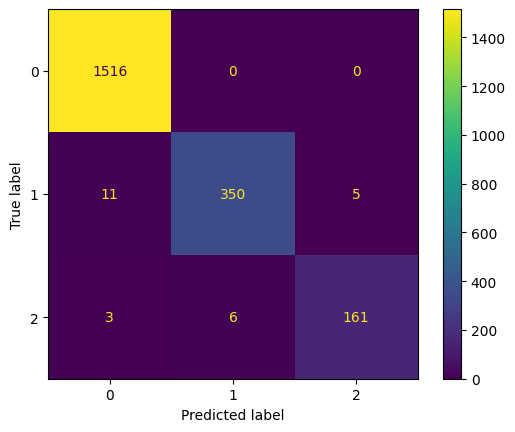

accuracy,NOT_NEEDED/precision,NOT_NEEDED/recall,SOON/precision,SOON/recall,URGENT/precision,URGENT/recall
0.988 ± 0.001,0.991 ± 0.001,0.999 ± 0.001,0.982 ± 0.006,0.96 ± 0.011,0.97 ± 0.008,0.949 ± 0.01


In [13]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

def trainRandomForest(nSplits, nEstimators, randomState):
    kfold = KFold(n_splits=nSplits, shuffle=True, random_state=randomState)
    reports = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Initialize Random Forest classifier
        rf = RandomForestClassifier(n_estimators=nEstimators, random_state=randomState)
    
        # Train the classifier
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        y_pred_bool = np.argmax(y_pred, axis=1)
        y_test_bool = np.argmax(y_test, axis=1)

        cr = classification_report(y_test_bool, y_pred_bool, zero_division=np.nan, output_dict=True)
        reports.append(cr)

        cm = confusion_matrix(y_test_bool, y_pred_bool)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()

    return reports

nSplits = 4
nEstimators = 10
randomState = 1337

reports = trainRandomForest(nSplits, nEstimators, randomState)
summariseReports(reports)

## Training a BTC

The implementation we use for the Boosted Tree Classifier (BTC) comes from the xgboost library.

It supports hyperparameters, but here we train it with the default settings to see how it performs.

We only need to pass the number of splits for the K-fold cross-validation, and a random state.

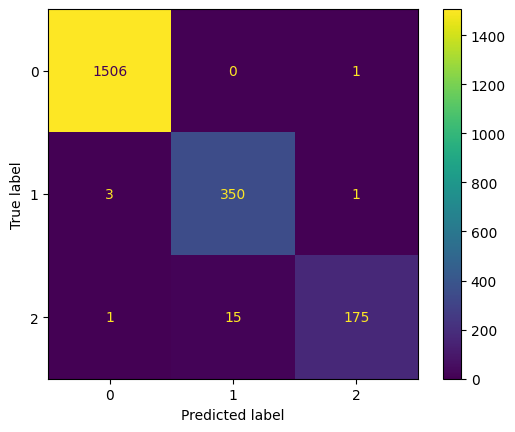

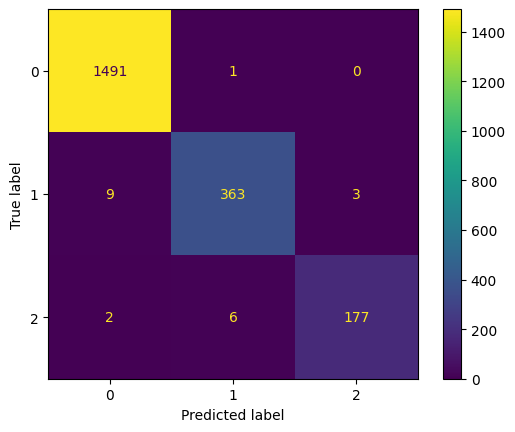

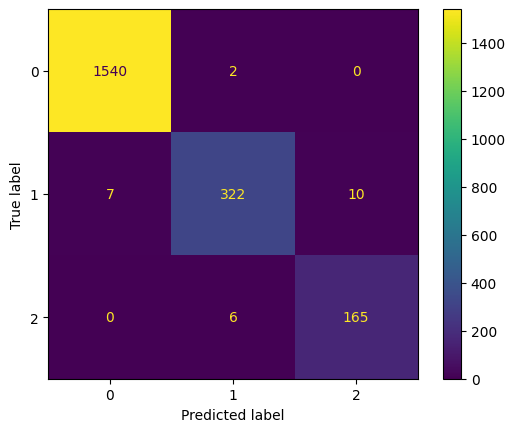

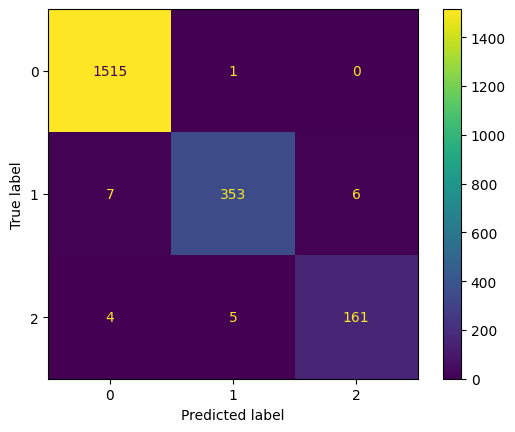

accuracy,NOT_NEEDED/precision,NOT_NEEDED/recall,SOON/precision,SOON/recall,URGENT/precision,URGENT/recall
0.989 ± 0.001,0.995 ± 0.002,0.999 ± 0.0,0.975 ± 0.01,0.968 ± 0.014,0.97 ± 0.018,0.946 ± 0.018


In [14]:
from sklearn.model_selection import KFold
import xgboost as xgb

def trainBTC(nSplits, randomState):
    kfold = KFold(n_splits=nSplits, shuffle=True, random_state=randomState)
    reports = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Initialize Boosted Tree classifier
        btc = xgb.XGBClassifier()
    
        # Train the classifier
        btc.fit(X_train, y_train)

        y_pred = btc.predict(X_test)

        y_pred_bool = np.argmax(y_pred, axis=1)
        y_test_bool = np.argmax(y_test, axis=1)

        cr = classification_report(y_test_bool, y_pred_bool, zero_division=np.nan, output_dict=True)
        reports.append(cr)

        cm = confusion_matrix(y_test_bool, y_pred_bool)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()

    return reports

nSplits = 4
randomState = 1337

reports = trainBTC(nSplits, randomState)
summariseReports(reports)

## References

[1] Brownlee, J. Aug 7, 2022. "Multi-Class Classification Tutorial with the Keras Deep Learning Library", https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

[2] Yadav, S. Nov 1, 2018. "Intro to Recurrent Neural Networks LSTM | GRU”, https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

